In [1]:
import pandas as pd
import numpy as np

The creators of Pycaret strongly recommend setting up a new virtual environment when using Pycaret to avoid potential conflicts with other libaries. I've been on project teams where individuals have attempted Pycaret installation into their global python environment and had issues. 

Another easy option is to use Google Colab, which I used to build this notebook. The advantage of Colab is there is no need to set up a virtual environment, I haven't seen any dependancy issues, and you get the benefit of Google's free and fast cloud processing with very similar functionality to Jupyter notebooks. 

In [2]:
pip install pycaret

     |████████████████████████████████| 266kB 3.9MB/s 
     |████████████████████████████████| 112kB 24.6MB/s 
     |████████████████████████████████| 1.4MB 21.4MB/s 
     |████████████████████████████████| 276kB 20.9MB/s 
     |████████████████████████████████| 14.2MB 199kB/s 
     |████████████████████████████████| 81kB 9.0MB/s 
     |████████████████████████████████| 174kB 50.3MB/s 
     |████████████████████████████████| 256kB 12.0MB/s 
     |████████████████████████████████| 61kB 7.0MB/s 
     |████████████████████████████████| 1.7MB 35.0MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.0MB 35.0MB/s 
     |████████████████████████████████| 6.8MB 39.4MB/s 
     |████████████████████████████████| 1.1MB 38.1MB/s 
     |████████████████████████████████| 61kB 7.0MB/s 
     |████████████████████████████████| 645kB 31.0MB/s

Now we will import the regression module.

In [3]:
from pycaret.regression import *

Additionally, we need to enable usage of Pycaret in Google Colab. If your using a virtual envronment in Jupyter, for example, you can skip this step.

In [4]:
from pycaret.utils import enable_colab
enable_colab()

Colab mode enabled.


For this tutorial, I am using a median listing price time series for Chicago I created in excel by subsetting this dataset from Zillow. Follow the link for the full Zillow dataset with all median listing price time series for all markets that Zillow tracks. OR you can just download the Chicago subset I created at Github. 

To read a .csv file into Colab, we need to import it into the Colab environment. No long path string necessary!

In [5]:
from google.colab import files
uploaded = files.upload()

Saving Zillow_Chicago_Month.csv to Zillow_Chicago_Month.csv


Import the io module and read in the file that we just uploaded into Colab. Notice, there's a bit of extra syntax in the pd.read_csv() function. 

In [6]:
import io
raw = pd.read_csv(io.BytesIO(uploaded['Zillow_Chicago_Month.csv']))
raw.head()

month_year  median_listing_price
0     3/1/08                250000
1     4/1/08                250000
2     5/1/08                251500
3     6/1/08                254000
4     7/1/08                260000

In [7]:
# defining our "data" dataframe for modelling to distinguish it from our "raw" imported data

data = raw[['month_year','median_listing_price']]

# casting our date column into a datetime object

data['month_year'] = pd.to_datetime(data['month_year'])

# checking our head and tail to confirm our date range
data.head(), data.tail()

(  month_year  median_listing_price
 0 2008-03-01                250000
 1 2008-04-01                250000
 2 2008-05-01                251500
 3 2008-06-01                254000
 4 2008-07-01                260000,     month_year  median_listing_price
 154 2021-01-01                260000
 155 2021-02-01                253000
 156 2021-03-01                255000
 157 2021-04-01                269000
 158 2021-05-01                283000)

In [8]:
# checking datatypes and shape

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   month_year            159 non-null    datetime64[ns]
 1   median_listing_price  159 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.6 KB


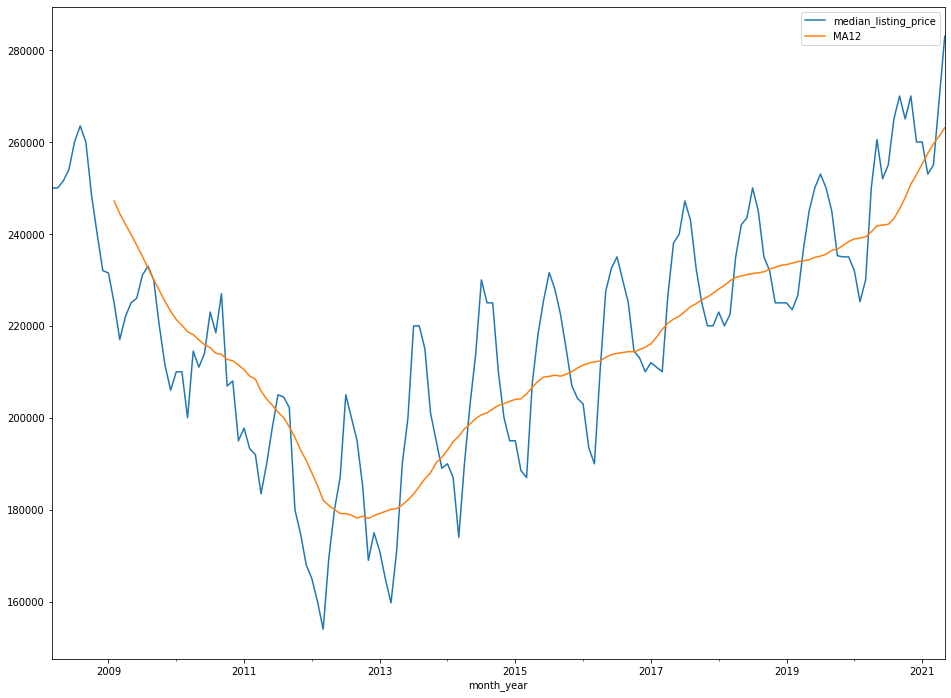

In [9]:
# creating a rolling 12 month mean so we can see the trend more clearly

data['MA12'] = data['median_listing_price'].rolling(12).mean()

# time series plot of median listing price for Chicago and the rolling 12-month average

data.plot.line(x='month_year', y=['median_listing_price','MA12'], figsize=(16,12));

From looking at this plot, we can anticipate our regression models are going to have a hard time modelling this time series. Let's choose a subset of this time series that is more linear, starting at 2013 (the beginning of the housing market's climb out of the great recession) instead of 2008. 

In [10]:
# subsetting to 2013 through present

data = data[(data['month_year'] > '2012-12-01') & (data['month_year'] < '2021-06-01')]
data = data.reset_index(drop=True)

# confirming we have the date range we want

data.head(), data.tail()

(  month_year  median_listing_price           MA12
 0 2013-01-01                171000  179208.333333
 1 2013-02-01                165000  179625.000000
 2 2013-03-01                159750  180104.166667
 3 2013-04-01                171000  180229.166667
 4 2013-05-01                190000  181062.500000,
     month_year  median_listing_price           MA12
 96  2021-01-01                260000  255231.666667
 97  2021-02-01                253000  257544.166667
 98  2021-03-01                255000  259627.500000
 99  2021-04-01                269000  261210.833333
 100 2021-05-01                283000  263083.333333)

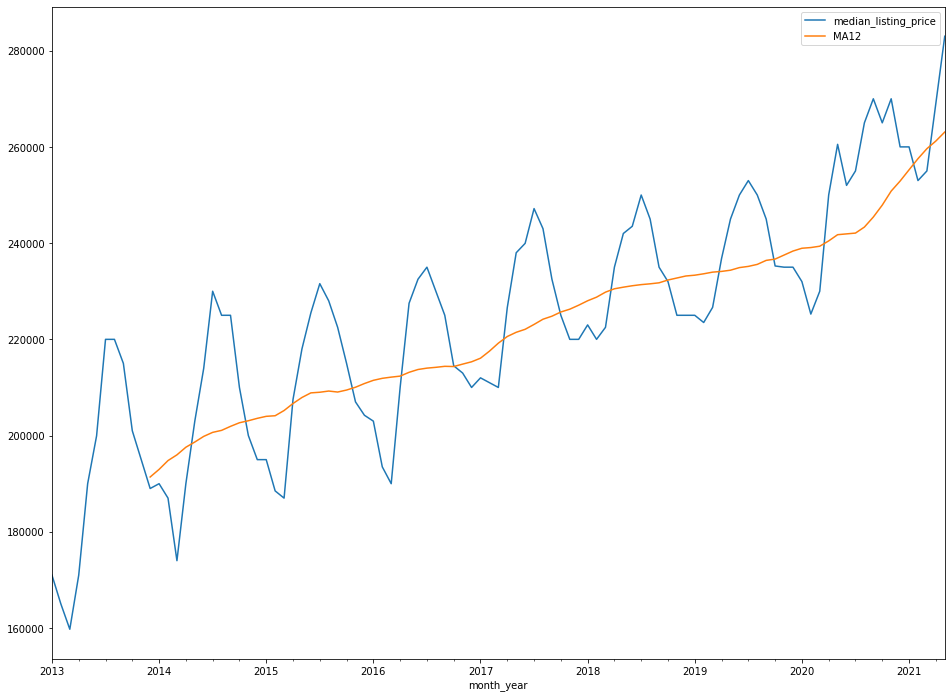

In [11]:
# running the same plot as before on our new subset

data['MA12'] = data['median_listing_price'].rolling(12).mean()
data.plot.line(x='month_year', y=['median_listing_price','MA12'], figsize=(16,12));

Much better! We can work with this! 

Generally, regression is not recommended for producing time series forecasts. A more traditional approach would be to use statistical models like ARIMA or SARIMA. 

However, by turning our time series into a regression-ready dataset and taking advantage of some powerful optional parameters in Pycaret's simple-to-implement preprocessing function, we can easily and quickly use regression to start producing forecasts. 

Overall, the approach below is to split our date column up into regression-ready features. The year becomes a numerical variable to help our models the trend and the month becomes a categorical variable to help our models with seasonality. 

In [12]:
# iterating through month_year and pupulating new a column with month int

data['Month'] = [i.month for i in data['month_year']]

# iterating through month_year and pupulating new a column with year int

data['Year'] = [i.year for i in data['month_year']]

# creating an int series to help us with sequencing

data['Series'] = np.arange(1,len(data)+1).astype('int64')

# dropping columns we no longer need

data.drop(['month_year', 'MA12'], axis=1, inplace=True)

data = data[['Series', 'Year', 'Month', 'median_listing_price']]

data.head()

Series  Year  Month  median_listing_price
0       1  2013      1                171000
1       2  2013      2                165000
2       3  2013      3                159750
3       4  2013      4                171000
4       5  2013      5                190000

Now that we have turned our time series into a dataframe that we can regress on, let's create a test-train split and also some different validation sets.

NB: 

As you'll see, the models will only train on 2013 through 2017 data. 

We will test our models on only 2018 data.

We will then refit/finalize our chosen model on our combined test and train set (2013 through 2018).

Then we will validate our finalized model on three different datasets: 2019, 2020, and the first part of 2021 that we have data for. This will give us an idea of how well (or not well) forecasts from our finalized model do over time.

Finally, we will use our finalized model to forecast the rest of 2021 and all of 2022.





In [13]:
# train and test splits that we will feed directly to our modelling pipeline for training, testing, and refitting

train = data[data['Year'] < 2018]
test = data[(data['Year'] >= 2018) & (data['Year'] < 2019)]

# validation sets that we will test our finalized model on

validate1 = data[(data['Year'] >= 2019) & (data['Year'] < 2020)]
validate2 = data[(data['Year'] >= 2020) & (data['Year'] < 2021)]
validate3 = data[data['Year'] >= 2021]

# checking df shapes

train.shape, test.shape, validate1.shape, validate2.shape, validate3.shape

((60, 4), (12, 4), (12, 4), (12, 4), (5, 4))

This is Pycaret's setup() function, which is required before training models. Think of the setup function as an automated preprocessing function with some powerful optional parameters.

To run setup(), you are only required to pass in a dataframe and specify the name of the target column. However, this will not work for our purposes. Normally, when you pass in your data, setup() creates the train/test split randomly using shuffling. This will not work for time series data because we don't want our models training on more recent dates (i.e., leakage). 

For time series data, we also need to adjust the default fold strategy from a random k-fold cross validation to a time series k-fold cross validation that maintains proper date sequnce within each fold.  

In [55]:
# explicitly pass test and train set. When explicitly passed, data is not suffled between sets

# specifiy target column

# set k-fold cross validation strategy to 'timeseries'

# setting numeric and categorical features is optional, but this ensures our year and series features are preprocessed as numerical

# set k-folds, default is 10. Can cause issues if k-fold number is too high relative to size of train data

# transforming target and features is optional. can also experiment with setting to True

# session_id acts as a random seed so results are consistent

# log experiments for Pycaret's experiment log

s = setup(data = train, test_data = test,  
          target = 'median_listing_price',   
          fold_strategy = 'timeseries', 
          numeric_features = ['Year', 'Series'], 
          fold = 3, 
          transform_target = False, 
          session_id = 123, 
          data_split_shuffle=False,
          log_experiment=True, experiment_name = 'ZillowMonthly') 

# the output will first show you the datatypes its imputed to each of your features

# if the datatypes are correct, press enter

# if not, type quit and manually set the feature types within the function

Description                 Value
0                               session_id                   123
1                                   Target  median_listing_price
2                            Original Data               (60, 4)
3                           Missing Values                 False
4                         Numeric Features                     2
5                     Categorical Features                     1
6                         Ordinal Features                 False
7                High Cardinality Features                 False
8                  High Cardinality Method                  None
9                    Transformed Train Set              (60, 14)
10                    Transformed Test Set              (12, 14)
11                      Shuffle Train-Test                 False
12                     Stratify Train-Test                 False
13                          Fold Generator       TimeSeriesSplit
14                             Fold Number                     3
15                                CPU Jobs                    -1
16                                 Use GPU                 False
17                          Log Experiment                  True
18                         Experiment Name         ZillowMonthly
19                                     USI                  5cd7
20                         Imputation Type                simple
21          Iterative Imputation Iteration                  None
22                         Numeric Imputer                  mean
23      Iterative Imputation Numeric Model                  None
24                     Categorical Imputer              constant
25  Iterative Imputation Categorical Model                  None
26           Unknown Categoricals Handling        least_frequent
27                               Normalize                 False
28                        Normalize Method                  None
29                          Transformation                 False
30                   Transformation Method                  None
31                                     PCA                 False
32                              PCA Method                  None
33                          PCA Components                  None
34                     Ignore Low Variance                 False
35                     Combine Rare Levels                 False
36                    Rare Level Threshold                  None
37                         Numeric Binning                 False
38                         Remove Outliers                 False
39                      Outliers Threshold                  None
40                Remove Multicollinearity                 False
41             Multicollinearity Threshold                  None
42             Remove Perfect Collinearity                  True
43                              Clustering                 False
44                    Clustering Iteration                  None
45                     Polynomial Features                 False
46                       Polynomial Degree                  None
47                    Trignometry Features                 False
48                    Polynomial Threshold                  None
49                          Group Features                 False
50                       Feature Selection                 False
51                Feature Selection Method               classic
52            Features Selection Threshold                  None
53                     Feature Interaction                 False
54                           Feature Ratio                 False
55                   Interaction Threshold                  None
56                        Transform Target                 False
57                 Transform Target Method               box-cox

If we call our setup variable that we instantiated above, we get the preprocessing operations performed on the dataset, and the test and train sets. The main reason I am showing this is so we can see how setup() has automatically one-hot-encoded the month column, which we defined as categorical, into 12 different features that the models can regress on. This will help the models capture seasonal patterns in the data.

In [56]:

s

('5cd7',
 None,
     Series    Year  Month_1  Month_10  ...  Month_6  Month_7  Month_8  Month_9
 60    61.0  2018.0      1.0       0.0  ...      0.0      0.0      0.0      0.0
 61    62.0  2018.0      0.0       0.0  ...      0.0      0.0      0.0      0.0
 62    63.0  2018.0      0.0       0.0  ...      0.0      0.0      0.0      0.0
 63    64.0  2018.0      0.0       0.0  ...      0.0      0.0      0.0      0.0
 64    65.0  2018.0      0.0       0.0  ...      0.0      0.0      0.0      0.0
 65    66.0  2018.0      0.0       0.0  ...      1.0      0.0      0.0      0.0
 66    67.0  2018.0      0.0       0.0  ...      0.0      1.0      0.0      0.0
 67    68.0  2018.0      0.0       0.0  ...      0.0      0.0      1.0      0.0
 68    69.0  2018.0      0.0       0.0  ...      0.0      0.0      0.0      1.0
 69    70.0  2018.0      0.0       1.0  ...      0.0      0.0      0.0      0.0
 70    71.0  2018.0      0.0       0.0  ...      0.0      0.0      0.0      0.0
 71    72.0  2018.0     

This is where things get fun! Pycaret's rapid multiple model function is compare_models.

In [57]:
# our preprocessed data is already loaded in Pycaret's virtual pipeline. No need to pass any data!

# we can define a variable that stores a preselected number of the best models. Default for n_iter is 1

best = compare_models(n_select=3)

# we can also the pull() function to output our model results as a dataframe, whereas the output of compare_models() above is the models themselves
best_results = pull()

Model          MAE           MSE  \
ridge                    Ridge Regression    7486.4222  8.062960e+07   
lasso                    Lasso Regression    8839.0055  1.111571e+08   
lr                      Linear Regression    8848.6610  1.113626e+08   
llar         Lasso Least Angle Regression    9238.0584  1.196224e+08   
en                            Elastic Net   10695.8779  1.584207e+08   
et                  Extra Trees Regressor    9710.6422  1.720600e+08   
huber                     Huber Regressor   11337.3967  2.329080e+08   
br                         Bayesian Ridge   12003.1971  2.572395e+08   
rf                Random Forest Regressor   12705.8991  2.620887e+08   
ada                    AdaBoost Regressor   12814.5802  2.588727e+08   
omp           Orthogonal Matching Pursuit   13702.1230  2.758709e+08   
par          Passive Aggressive Regressor   13829.1443  3.017526e+08   
dt                Decision Tree Regressor   14012.8667  3.253905e+08   
gbr           Gradient Boosting Regressor   14103.3068  3.513671e+08   
knn                 K Neighbors Regressor   16295.0889  3.871141e+08   
lightgbm  Light Gradient Boosting Machine   16914.6425  4.458834e+08   
lar                Least Angle Regression  156848.7952  6.843461e+10   

                 RMSE        R2   RMSLE    MAPE  TT (Sec)  
ridge       8829.2746    0.5842  0.0412  0.0355    0.0167  
lasso      10181.8096    0.4334  0.0458  0.0410    0.0200  
lr         10192.9950    0.4323  0.0459  0.0410    0.8667  
llar       10587.3938    0.3922  0.0476  0.0429    0.0233  
en         12555.0394    0.1653  0.0591  0.0509    0.0200  
et         11273.2161    0.1193  0.0535  0.0445    0.4667  
huber      13638.2210   -0.1536  0.0639  0.0521    0.0367  
br         14664.0764   -0.2778  0.0700  0.0557    0.0200  
rf         14474.0561   -0.3206  0.0687  0.0584    0.5300  
ada        14823.5896   -0.3337  0.0699  0.0584    0.0833  
omp        16282.9117   -0.4270  0.0769  0.0639    0.0167  
par        17072.9693   -0.5488  0.0798  0.0670    0.0233  
dt         17131.0506   -0.6634  0.0811  0.0649    0.0167  
gbr        16570.3368   -0.7460  0.0800  0.0658    0.0433  
knn        19130.9756   -0.9812  0.0902  0.0741    0.0833  
lightgbm   20907.8239   -1.3110  0.0979  0.0754    0.1933  
lar       157852.5789 -332.5342  0.4170  0.7572    0.0200

In [58]:
# best 3 models stored in one variable

best

[Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
       normalize=False, random_state=123, solver='auto', tol=0.001),
 Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
       normalize=False, positive=False, precompute=False, random_state=123,
       selection='cyclic', tol=0.0001, warm_start=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)]

In [59]:
# compare_models() results as a dataframe

best_results

Model          MAE  ...    MAPE  TT (Sec)
ridge                    Ridge Regression    7486.4222  ...  0.0355    0.0167
lasso                    Lasso Regression    8839.0055  ...  0.0410    0.0200
lr                      Linear Regression    8848.6610  ...  0.0410    0.8667
llar         Lasso Least Angle Regression    9238.0584  ...  0.0429    0.0233
en                            Elastic Net   10695.8779  ...  0.0509    0.0200
et                  Extra Trees Regressor    9710.6422  ...  0.0445    0.4667
huber                     Huber Regressor   11337.3967  ...  0.0521    0.0367
br                         Bayesian Ridge   12003.1971  ...  0.0557    0.0200
rf                Random Forest Regressor   12705.8991  ...  0.0584    0.5300
ada                    AdaBoost Regressor   12814.5802  ...  0.0584    0.0833
omp           Orthogonal Matching Pursuit   13702.1230  ...  0.0639    0.0167
par          Passive Aggressive Regressor   13829.1443  ...  0.0670    0.0233
dt                Decision Tree Regressor   14012.8667  ...  0.0649    0.0167
gbr           Gradient Boosting Regressor   14103.3068  ...  0.0658    0.0433
knn                 K Neighbors Regressor   16295.0889  ...  0.0741    0.0833
lightgbm  Light Gradient Boosting Machine   16914.6425  ...  0.0754    0.1933
lar                Least Angle Regression  156848.7952  ...  0.7572    0.0200

[17 rows x 8 columns]

The compare_models() function gives us a great baseline to start with. From here we can call individual models we want to examine further, tune them, ensemble them, or combine them with other models to improve prediction performance.

The create_model() function simply calls an individual model from compare_models(). It is not retraining. Notice how the ridge model I called has the exact same mean scores as the output above. Additionally, we also see the scores of each k-fold. 

In [60]:
# model is called by passing in the model abbreviation as a string

# you can get the abbreviation for each model from the first column of the compare_models() output above

ridge = create_model('ridge')

MAE           MSE        RMSE      R2   RMSLE    MAPE
0     7099.7334  7.956049e+07   8919.6689  0.6123  0.0441  0.0355
1     9443.5332  1.163187e+08  10785.1143  0.4307  0.0492  0.0443
2     5916.0000  4.600964e+07   6783.0405  0.7096  0.0303  0.0267
Mean  7486.4222  8.062960e+07   8829.2746  0.5842  0.0412  0.0355
SD    1465.8374  2.871350e+07   1635.0896  0.1156  0.0080  0.0072

In [61]:
# notice how our model is stored conveniently in this variable

ridge

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=123, solver='auto', tol=0.001)

From here, we can go a lot of different directions to try to improve our model performance. We can tune our model (or other versions of our model) with tune_model(). By default, tune_model() goes through 10 iterations of a random grid search, randomly selecting one value from a pre-defined grid of hyperparameters. Increasing the number of iterations using the n_iter parameter could improve model performance but will also increase computation time as well as producing an overfit model. 

In this case, I'm increasing n_iter to 50.

In [62]:
tuned_ridge = tune_model(ridge, n_iter=50)

MAE           MSE       RMSE      R2   RMSLE    MAPE
0     4197.5332  2.704050e+07  5200.0483  0.8682  0.0260  0.0210
1     7391.1333  7.458931e+07  8636.5107  0.6349  0.0388  0.0343
2     5030.5000  3.520952e+07  5933.7612  0.7777  0.0267  0.0224
Mean  5539.7222  4.561311e+07  6590.1068  0.7603  0.0305  0.0259
SD    1352.5903  2.075891e+07  1477.7033  0.0960  0.0059  0.0060

Pycaret also has an ensembling function where you can use boosting or bagging to try and increase model performance. You can pass in your orginal model or your tuned model and compare results. In this case, I'm trying both bagging and boosting on my tuned ridge model.

There's a lot more to say about bagging and boosting, but, generally, you can try bagging if you think your model is overfitting and boosting if you think your model is underfitting.

When doing this type of regression on monthly time series with a relatively low number of observations, I've usually found that bagging helps the models generalize better than boosting, but this is of course highly dependent on your data. 

In [63]:
bagged_tuned_ridge = ensemble_model(tuned_ridge, method='Bagging' )

MAE           MSE       RMSE      R2   RMSLE    MAPE
0     6918.8125  6.485683e+07  8053.3735  0.6839  0.0379  0.0326
1     5323.2373  3.908472e+07  6251.7778  0.8087  0.0292  0.0250
2     5222.3853  3.423990e+07  5851.4868  0.7839  0.0262  0.0232
Mean  5821.4784  4.606048e+07  6718.8794  0.7588  0.0311  0.0269
SD     777.0240  1.343739e+07   957.6757  0.0539  0.0050  0.0040

In [64]:
boosted_tuned_ridge = ensemble_model(tuned_ridge, method='Boosting' )

MAE           MSE       RMSE      R2   RMSLE    MAPE
0     4771.4282  3.247420e+07  5698.6133  0.8417  0.0279  0.0233
1     8366.3662  9.595409e+07  9795.6162  0.5304  0.0439  0.0388
2     4010.4666  2.346038e+07  4843.5913  0.8519  0.0217  0.0179
Mean  5716.0870  5.062955e+07  6779.2736  0.7413  0.0312  0.0267
SD    1899.6053  3.225985e+07  2161.2508  0.1492  0.0093  0.0088

There is also a blend model function where you can pass a list or (in our case) a variable containing multiple models--rememeber we defined this variable to store the top 3 models when we initialized the compare_models() function. 

The blender will average the individual model predictions to form a final prediction. With this type of regression on time series, my results using this have been mixed to worse, but for certain datasets this could be a great option and is very easy to implement. 

In [65]:
# pass in our best variable containing top 3 models

blender = blend_models(best)

MAE           MSE        RMSE      R2   RMSLE    MAPE
0      7460.4824  7.750618e+07   8803.7588  0.6223  0.0429  0.0368
1     10980.3311  1.567017e+08  12518.0566  0.2330  0.0549  0.0505
2      5874.0947  4.619465e+07   6796.6646  0.7084  0.0306  0.0265
Mean   8104.9694  9.346752e+07   9372.8267  0.5212  0.0428  0.0379
SD     2133.8439  4.650468e+07   2370.1562  0.2068  0.0099  0.0098

Pycaret also has several easy plotting and evaluation functions where you can examine model parameters, residual plots, error plots, feature importance, etc.

In [66]:
# produces all inclusive interactive output

# click different buttons to investigate your model

# not all buttons will work for every model.

evaluate_model(bagged_tuned_ridge)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

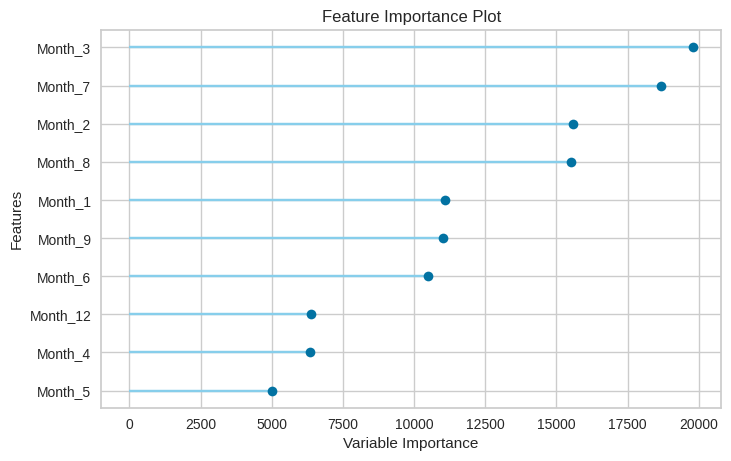

In [67]:
# examine feature importance

plot_model(tuned_ridge, plot='feature')

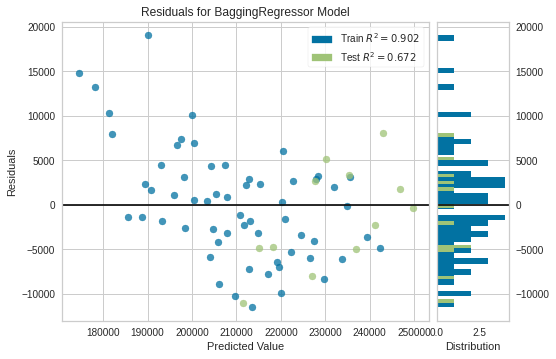

In [68]:
# examine residuals of train and test sets

plot_model(bagged_tuned_ridge, plot='residuals')

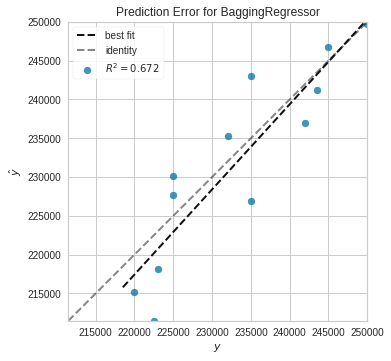

In [69]:
# examine test set prediction errors

plot_model(bagged_tuned_ridge, plot='error')

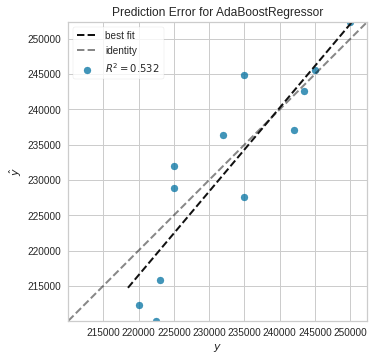

In [70]:
plot_model(boosted_tuned_ridge, plot='error')

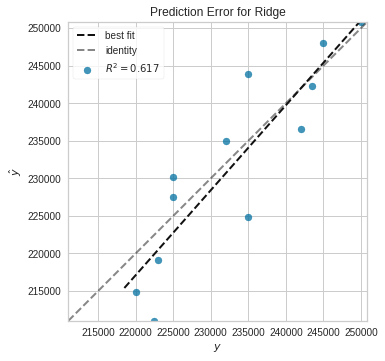

In [71]:
plot_model(tuned_ridge, plot='error')

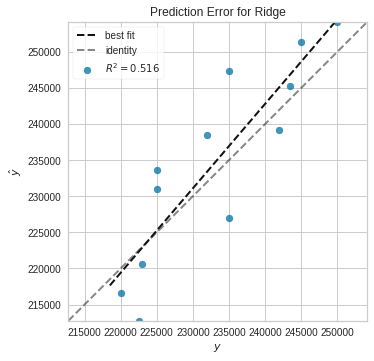

In [72]:
plot_model(ridge, plot='error')

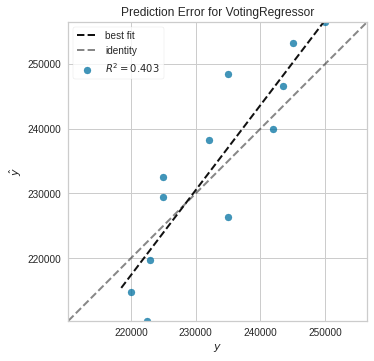

In [73]:
plot_model(blender, plot='error')

Once we like a model, we can try it out by using it to make predictions on our test set using predict_model(). You simply pass the selected model and dataset into the function and it will make predictions using that model on your dataset. 

When you don't pass in a dataset, the function simply performs the predictions on the test set that you passed into the setup() function, which is still sitting in the modeling pipeline. Notice that our output has the same date range (year 2018) that we defined in our test data. 

We can use also the predict function on some of the other models we trained to see if any of them generalize to our 2018 data better. 

In [74]:
# bagged model does better

predict_model(bagged_tuned_ridge)

Model          MAE         MSE  ...     R2   RMSLE    MAPE
0  Ridge Regression  4755.778809  31160352.0  ...  0.672  0.0247  0.0207

[1 rows x 7 columns]

Series    Year  Month_1  ...  Month_9  median_listing_price          Label
0     61.0  2018.0      1.0  ...      0.0              223000.0  218201.203125
1     62.0  2018.0      0.0  ...      0.0              220000.0  215168.000000
2     63.0  2018.0      0.0  ...      0.0              222500.0  211479.796875
3     64.0  2018.0      0.0  ...      0.0              235000.0  226963.046875
4     65.0  2018.0      0.0  ...      0.0              242000.0  237002.953125
5     66.0  2018.0      0.0  ...      0.0              243500.0  241252.843750
6     67.0  2018.0      0.0  ...      0.0              250000.0  249669.906250
7     68.0  2018.0      0.0  ...      0.0              245000.0  246723.953125
8     69.0  2018.0      0.0  ...      1.0              235000.0  243034.250000
9     70.0  2018.0      0.0  ...      0.0              232000.0  235327.093750
10    71.0  2018.0      0.0  ...      0.0              225000.0  230080.953125
11    72.0  2018.0      0.0  ...      0.0              225000.0  227640.843750

[12 rows x 16 columns]

In [75]:
# boosted model does worse than bagged on test data even though it did better than bagged model on train data. probably overfit

predict_model(boosted_tuned_ridge)

Model          MAE         MSE  ...      R2   RMSLE   MAPE
0  Ridge Regression  5732.458496  44499684.0  ...  0.5317  0.0296  0.025

[1 rows x 7 columns]

Series    Year  Month_1  ...  Month_9  median_listing_price     Label
0     61.0  2018.0      1.0  ...      0.0              223000.0  215769.5
1     62.0  2018.0      0.0  ...      0.0              220000.0  212312.5
2     63.0  2018.0      0.0  ...      0.0              222500.0  210052.0
3     64.0  2018.0      0.0  ...      0.0              235000.0  227556.0
4     65.0  2018.0      0.0  ...      0.0              242000.0  237091.5
5     66.0  2018.0      0.0  ...      0.0              243500.0  242603.5
6     67.0  2018.0      0.0  ...      0.0              250000.0  252405.5
7     68.0  2018.0      0.0  ...      0.0              245000.0  245583.0
8     69.0  2018.0      0.0  ...      1.0              235000.0  244866.5
9     70.0  2018.0      0.0  ...      0.0              232000.0  236435.5
10    71.0  2018.0      0.0  ...      0.0              225000.0  232019.5
11    72.0  2018.0      0.0  ...      0.0              225000.0  228864.5

[12 rows x 16 columns]

Before we move on to refitting/finalizing the model and trying it on our validation sets, we can pass our entire dataset (January 2013 - May 2021) into the predict function and visualize how the predicted values fit to our actual values.

NB: here, we are NOT retraining or refitting the model to our entire dataset. I am simply passing the entire dataset into our static model so we can visualize our predicted versus actual values for the entire series. Call it "EDA through modelling." 

By doing this, and inspecting our plot below, I can hypothesize that our model will perform well on 2019 validation data, slightly worse on 2020 validation data, and much worse on 2021 validation data just from looking at how our predicted line fits our actual line. 

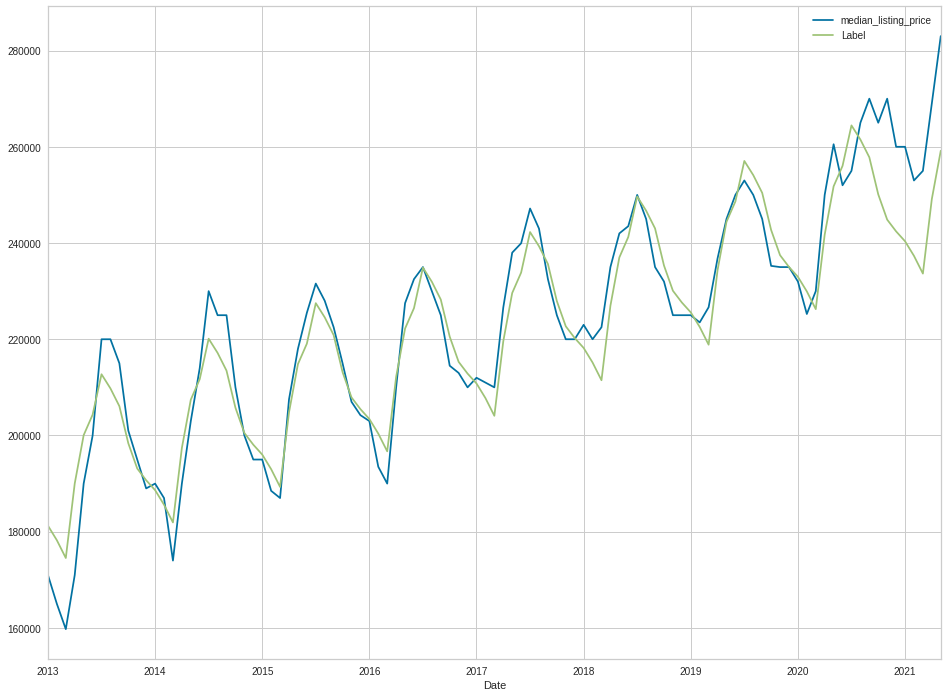

In [76]:
# in the predict function, we pass our model and our full dataset

# the output is a dataframe with our feature columns, the actual target column, and the predicted target column

predictions = predict_model(bagged_tuned_ridge, data=data)

# we append a datetime column with the correct date range onto our predictions dataframe

predictions['Date'] = pd.date_range(start='2013-01-01', end = '2021-05-01', freq = 'MS')

# and plot

predictions.plot.line(x='Date', y=['median_listing_price','Label'], figsize=(16,12));

To test this hypothesis, let's finalize our model. 

When we use the finalize function, our model refits to both train and test data that we passed into the setup function at the beginning of the pipeline. This ensures that we are not leaving any predictive power contained in our test data on the table. 

As a reminder, our train and test combined date range is 2013 through 2018.

Finally, as before, all model details are stored in our single variable so that we can easily pass it into other functions.

In [77]:
final_ridge = finalize_model(bagged_tuned_ridge)

In [78]:
final_ridge

BaggingRegressor(base_estimator=Ridge(alpha=0.25, copy_X=True,
                                      fit_intercept=True, max_iter=None,
                                      normalize=True, random_state=123,
                                      solver='auto', tol=0.001),
                 bootstrap=True, bootstrap_features=False, max_features=1.0,
                 max_samples=1.0, n_estimators=10, n_jobs=None, oob_score=False,
                 random_state=123, verbose=0, warm_start=False)

Now I am going to deploy our model on our different validation sets that I created. Remember, I created 3 validation sets--one for 2019, 2020, and the first half of 2021. 

Let's see how our model does on each of these validation sets!

In [79]:
# passing our finalized ridge model and 2019 validation data into predict function

predictions_future_2019 = predict_model(final_ridge, data=validate1)
predictions_future_2019.rename(columns = {'Label': 'Label_2019'}, inplace=True)
predictions_future_2019

Series  Year  Month  median_listing_price     Label_2019
72      73  2019      1                225000  225590.156250
73      74  2019      2                223500  222556.843750
74      75  2019      3                226650  218868.656250
75      76  2019      4                236800  234351.906250
76      77  2019      5                245000  244391.906250
77      78  2019      6                250000  248641.656250
78      79  2019      7                253000  257058.796875
79      80  2019      8                250000  254112.796875
80      81  2019      9                245000  250422.953125
81      82  2019     10                235250  242716.000000
82      83  2019     11                235000  237469.843750
83      84  2019     12                235000  235029.546875

In [83]:
# using Pycaret's check metric function to check various scores

# the parameters are the actual target column, the predictions column, and the selected score as a string

from pycaret.utils import check_metric

R2 = check_metric(predictions_future_2019.median_listing_price, predictions_future_2019.Label_2019, 'R2')
print(f'R2 = {R2}')
MAE = check_metric(predictions_future_2019.median_listing_price, predictions_future_2019.Label_2019, 'MAE')
print(f'MAE = {MAE}')
RMSE = check_metric(predictions_future_2019.median_listing_price, predictions_future_2019.Label_2019, 'RMSE')**0.5
print(f'RMSE = {RMSE}')

R2 = 0.83
MAE = 3107.4271
RMSE = 4027.351129030097


That's pretty good! 

In this case our finalized model which was refit on 2013 through 2018 data, produces strong results on our 2019 validation data. 

The regression-based forecast seems to be doing a good job 12 months into the future. But does that good performance continue? 

We guessed that it wouldn't, but let's continue with our validation sets.



In [42]:
# passing our finalized ridge model and 2020 validation data into predict function

predictions_future_2020 = predict_model(final_ridge, data=validate2)
predictions_future_2020.rename(columns = {'Label': 'Label_2020'}, inplace=True)
predictions_future_2020

Series  Year  Month  median_listing_price     Label_2020
84      85  2020      1                232000  232979.156250
85      86  2020      2                225250  229945.953125
86      87  2020      3                230000  226257.703125
87      88  2020      4                250000  241741.000000
88      89  2020      5                260530  251780.953125
89      90  2020      6                252000  256030.656250
90      91  2020      7                255000  264447.843750
91      92  2020      8                265000  261501.843750
92      93  2020      9                270000  257812.203125
93      94  2020     10                265000  250105.000000
94      95  2020     11                270000  244858.906250
95      96  2020     12                260000  242418.750000

In [43]:
print(check_metric(predictions_future_2020.median_listing_price, predictions_future_2020.Label_2020, 'R2'))
print(check_metric(predictions_future_2020.median_listing_price, predictions_future_2020.Label_2020, 'MAE'))
print(check_metric(predictions_future_2020.median_listing_price, predictions_future_2020.Label_2020, 'RMSE')**0.5)

0.4089
9433.9375
11586.974775906781


Ah, as expected, our performance on 2020 validation data has decreased pretty rapidly. Remember, this might not be to fundamental flaws in our model. From inspecting the predicted vs. actual median listing price plot we made above, everything after about the first quarter of 2020 (the onset of covid in the U.S.) looks pretty unusual in historical terms. 

2021 looks even more unsual. Let's see if that's reflected in our model results for our January through May 2021 validation set. 

In [44]:
# passing our finalized ridge model and 2021 validation data into predict function

predictions_future_2021 = predict_model(final_ridge, data=validate3)
predictions_future_2021.rename(columns = {'Label': 'Label_2021'}, inplace=True)
predictions_future_2021

Series  Year  Month  median_listing_price     Label_2021
96       97  2021      1                260000  240367.906250
97       98  2021      2                253000  237334.750000
98       99  2021      3                255000  233646.453125
99      100  2021      4                269000  249129.843750
100     101  2021      5                283000  259169.906250

Indeed we are doing quite a bit worse. 

In [45]:
print(check_metric(predictions_future_2021.median_listing_price, predictions_future_2021.Label_2021, 'R2'))
print(check_metric(predictions_future_2021.median_listing_price, predictions_future_2021.Label_2021, 'MAE'))
print(check_metric(predictions_future_2021.median_listing_price, predictions_future_2021.Label_2021, 'RMSE')**0.5)

-2.3932
20070.2281
20245.93590944859


I think we can hypothesize that, excluding the hopefully once in a lifetime business cycle disruptions of COVID, our regression-based forecast is actually doing a pretty good job and is basically capturing the trend and seasonal patterns of 2013 through 2018 well enough to make accurate predictions for 2019. 

However, the model really fails to generalize in a market where those patterns see huge disruption. This is not that surprising, but I think it's an interesting exercise to trace our model's performance as we move into 2020 and 2021, and it gives us insight into how the housing market deviated from it's normal pattern during the pandemic period. 

Just from looking at the output dataframe above. We can see our model is totally undershooting the steep increase in median listing price during March, April, and May.

Using this rapid modeling pipeline in Pycaret to explore changes in a market through regressing on time series is incredibly useful! 



Now, let's actually forecast the future. Using our model trained on 2013 through 2018 data, we are going to forecast the 2nd half of 2021 and all of 2022. 

In [46]:
# creating date range

future_dates = pd.date_range(start = '2021-06-01', end = '2023-01-01', freq = 'MS')

future_df = pd.DataFrame()

# populating data frame Month, Year columns by iterating through data range

future_df['Month'] = [i.month for i in future_dates]
future_df['Year'] = [i.year for i in future_dates] 

# populating Series column with series array that starts where our 2021 validation series number left off

future_df['Series'] = np.arange(102,(102+len(future_dates)))

future_df.head()

Month  Year  Series
0      6  2021     102
1      7  2021     103
2      8  2021     104
3      9  2021     105
4     10  2021     106

In [47]:
# passing our final ridge model and future df through the predict function

predictions_future_06_2021_to_2023 = predict_model(final_ridge, data=future_df)
predictions_future_06_2021_to_2023.rename(columns = {'Label': 'Future_Label'}, inplace=True)
predictions_future_06_2021_to_2023

Month  Year  Series   Future_Label
0       6  2021     102  263419.562500
1       7  2021     103  271836.593750
2       8  2021     104  268890.750000
3       9  2021     105  265200.937500
4      10  2021     106  257493.953125
5      11  2021     107  252247.656250
6      12  2021     108  249807.546875
7       1  2022     109  247757.000000
8       2  2022     110  244723.703125
9       3  2022     111  241035.546875
10      4  2022     112  256518.796875
11      5  2022     113  266558.687500
12      6  2022     114  270808.562500
13      7  2022     115  279225.656250
14      8  2022     116  276279.656250
15      9  2022     117  272589.906250
16     10  2022     118  264882.750000
17     11  2022     119  259636.703125
18     12  2022     120  257196.453125
19      1  2023     121  255145.906250

In [48]:
# concatenating the output of the predict function with our original entire dataset

concat_df = pd.concat([data,predictions_future_06_2021_to_2023], axis=0)

# creating and appending the complete data range for time series plotting

concat_df_i = pd.date_range(start='2013-01-01', end = '2023-01-01', freq = 'MS')
concat_df['Date'] = concat_df_i
concat_df.head()

Series  Year  Month  median_listing_price  Future_Label       Date
0       1  2013      1              171000.0           NaN 2013-01-01
1       2  2013      2              165000.0           NaN 2013-02-01
2       3  2013      3              159750.0           NaN 2013-03-01
3       4  2013      4              171000.0           NaN 2013-04-01
4       5  2013      5              190000.0           NaN 2013-05-01

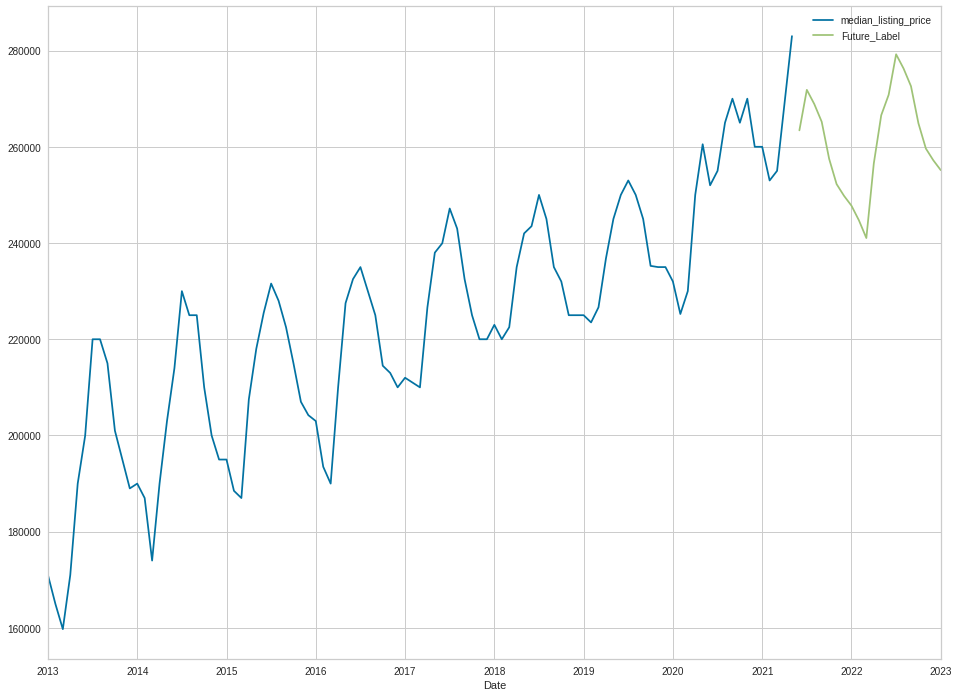

In [49]:
# plot of actual median listing price and predicted future prices

concat_df.plot.line(x='Date', y=['median_listing_price','Future_Label'], figsize=(16,12));

From this plot we can see our model is forcing the seasonal pattern onto its forecast for June 2021, even though May is spiked quite higher.

If we wanted our model to be even more robust, one approach could be to add 2019 data and refit it again. We could then assume 2020 and 2021 are outliers, and just predict 2022. Doing the forecast that way could give us a good idea of what the housing market looks like IF the housing market returns to normal patterns by 2022. 

That is an assumption, for sure, but that's just an example of an approach we could use if we had true investment dollars at stake. 

Wrapping up, using the save_model function saves our final ridge model and pipeline as a pickle file. The file is saved automatically to the directory of your notebook, or you can specify a path by passing it into the function.

In [50]:
save_model(final_ridge, 'Zillow Pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=['Year', 'Series'],
                                       target='median_listing_price',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_num...
                 ('dfs', 'passthrough'), ('pca', 'passthrough'),
                 ['trained_model',
                  BaggingRegressor(base_estimator=Ridge(alpha=0.25, copy_X=True,
                                                        fit_intercept=True,
                                                  

Once saved, we can easily recall the pipeline.

In [51]:
zillow_pipeline = load_model('Zillow Pipeline')

Transformation Pipeline and Model Successfully Loaded


In [52]:
print(zillow_pipeline)

Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=['Year', 'Series'],
                                      target='median_listing_price',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_num...
                ('dfs', 'passthrough'), ('pca', 'passthrough'),
                ['trained_model',
                 BaggingRegressor(base_estimator=Ridge(alpha=0.25, copy_X=True,
                                                       fit_intercept=True,
                                                       max_iter=No

Last cool feature, Pycaret logs your pipeline, generating all sorts of rich metadata. You can also access this log in a user friendly GUI in MLflow, which also works with Pycaret. But that's a topic for another day

In [53]:
get_logs()

run_id  ...                      tags.mlflow.log-model.history
0   a7e3550c91e740589059c16c30ef68c0  ...  [{"run_id": "a7e3550c91e740589059c16c30ef68c0"...
1   4192fc21dd0e471fa126c1b2069724fb  ...  [{"run_id": "4192fc21dd0e471fa126c1b2069724fb"...
2   7fde95777a6544ef973f0b13bfcac5f9  ...  [{"run_id": "7fde95777a6544ef973f0b13bfcac5f9"...
3   da783bb0d5e04c8596fc50919bd4709d  ...  [{"run_id": "da783bb0d5e04c8596fc50919bd4709d"...
4   69c6f22015994a65a26e8f7cb76a2224  ...  [{"run_id": "69c6f22015994a65a26e8f7cb76a2224"...
5   9a9e61bea38046928e81c5e7ab7b229e  ...  [{"run_id": "9a9e61bea38046928e81c5e7ab7b229e"...
6   109019c6d03b492ba1609095b244fbe8  ...  [{"run_id": "109019c6d03b492ba1609095b244fbe8"...
7   272c4a50ee7b42acbf2ed2b954b128d9  ...  [{"run_id": "272c4a50ee7b42acbf2ed2b954b128d9"...
8   dccadc7fc8194d1aa28ce52a3c65d721  ...  [{"run_id": "dccadc7fc8194d1aa28ce52a3c65d721"...
9   2d5a3ec5cbf44a7591fb5d2837e9d2fe  ...  [{"run_id": "2d5a3ec5cbf44a7591fb5d2837e9d2fe"...
10  75b7f088ae2e4a37bd4d2cb99b2c5913  ...  [{"run_id": "75b7f088ae2e4a37bd4d2cb99b2c5913"...
11  5163fc60af134e849d42e704ae66e297  ...  [{"run_id": "5163fc60af134e849d42e704ae66e297"...
12  a0c40b41a4724aceaf5cb083bd3d90e2  ...  [{"run_id": "a0c40b41a4724aceaf5cb083bd3d90e2"...
13  961577545671444dafe446abcce66754  ...  [{"run_id": "961577545671444dafe446abcce66754"...
14  09c23ce418e248308893cb0e4888ad72  ...  [{"run_id": "09c23ce418e248308893cb0e4888ad72"...
15  1b6f07224ffa448a94bbcd0c88ac8d32  ...  [{"run_id": "1b6f07224ffa448a94bbcd0c88ac8d32"...
16  9f5d61d70f4944c0b5628cc0d578c42b  ...  [{"run_id": "9f5d61d70f4944c0b5628cc0d578c42b"...
17  a7b891b6638c45b5b878984caf373968  ...  [{"run_id": "a7b891b6638c45b5b878984caf373968"...
18  f469f589d51f437bae2127d8c061ca4a  ...  [{"run_id": "f469f589d51f437bae2127d8c061ca4a"...
19  b4cc7bb18f1545dfbf1aa2669d3f3c3d  ...  [{"run_id": "b4cc7bb18f1545dfbf1aa2669d3f3c3d"...
20  e74a2403636e4e368a99b7b615ea9442  ...  [{"run_id": "e74a2403636e4e368a99b7b615ea9442"...
21  143694b6cac7477f8478057347985209  ...  [{"run_id": "143694b6cac7477f8478057347985209"...
22  845b149546dd471684cad599253bfb21  ...  [{"run_id": "845b149546dd471684cad599253bfb21"...
23  6690f56678304beba78be02a17f91544  ...                                               None

[24 rows x 192 columns]